In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import sys
import os
from dataclasses import dataclass
import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from llamawrapper import load_unemb_only, LlamaHelper
import seaborn as sns
from scipy.stats import bootstrap
from utils import plot_ci, plot_ci_plus_heatmap
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
# fix random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
sys.path.append('../tuned-lens')
from tuned_lens.nn.lenses import TunedLens,LogitLens

In [3]:
input_lang = 'fr'
target_lang = 'zh'
model_size = '13b'
out_dir = './visuals/logit'
prefix = "./data/langs/"
df_en_fr = pd.read_csv(f'{prefix}{input_lang}/clean.csv').reindex()
df_en_de = pd.read_csv(f'{prefix}{target_lang}/clean.csv').reindex()

In [4]:
# Parameters
model_size = "7b"
target_lang = "fr"
input_lang = "fr"


In [5]:
llama = AutoModelForCausalLM.from_pretrained(  # type: ignore
                f"meta-llama/Llama-2-{model_size}-hf",
                device_map={"": "cuda:0"},
                revision="main",
                torch_dtype="auto",
                local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
            )
#llama_lens = TunedLens.from_model_and_pretrained(llama,f"meta-llama/Llama-2-13b-hf").to("cuda:0")
#llama_lens = TunedLens.from_model_and_pretrained(llama,"../tuned-lens/my_lenses/chinese").to("cuda:0")
llama_lens = LogitLens.from_model(llama).to("cuda:0")
tokenizer = AutoTokenizer.from_pretrained(
                f"meta-llama/Llama-2-7b-hf",local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
            )

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
unemb = nn.Sequential(llama.model.norm, llama.lm_head)
print(unemb)
# prepare for energy plots
U = list(unemb[1].parameters())[0].detach().cpu().float()
weights = list(unemb[0].parameters())[0].detach().cpu().float()
print(f'U {U.shape} weights {weights.unsqueeze(0).shape}')
U_weighted = U.clone() 
#U_weighted = U_weighted / ((U_weighted**2).mean(dim=1, keepdim=True))**0.5
U_weighted *= weights.unsqueeze(0)
U_normalized = U_weighted / ((U_weighted**2).sum(dim=1, keepdim=True))**0.5
v = U.shape[0]
TT = U_normalized.T @ U_normalized
avgUU = (((U_normalized.T @ U_normalized)**2).sum() / v**2)**0.5
print(avgUU.item())

Sequential(
  (0): LlamaRMSNorm()
  (1): Linear(in_features=4096, out_features=32000, bias=False)
)
U torch.Size([32000, 4096]) weights torch.Size([1, 4096])


0.058621685951948166


In [7]:
count = 0
for idx, word in enumerate(df_en_de['word_translation']):
    if word in tokenizer.get_vocab() or '▁'+word in tokenizer.get_vocab():
        count += 1

print(f'for {target_lang} {count} of {len(df_en_de)} are single tokens')

if input_lang == target_lang:
    df_en_de_fr = df_en_de.copy()
    df_en_de_fr.rename(columns={'word_original': 'en', 
                                f'word_translation': target_lang if target_lang != 'en' else 'en_tgt'}, 
                                inplace=True)
else:
    df_en_de_fr = df_en_de.merge(df_en_fr, on=['word_original'], suffixes=(f'_{target_lang}', f'_{input_lang}'))
    df_en_de_fr.rename(columns={'word_original': 'en', 
                                f'word_translation_{target_lang}': target_lang if target_lang != 'en' else 'en_tgt', 
                                f'word_translation_{input_lang}': input_lang if input_lang != 'en' else 'en_in'}, 
                                inplace=True)
# delete all rows where en is contained in de or fr
if target_lang != 'en':
    for i, row in df_en_de_fr.iterrows():
        if row['en'].lower() in row[target_lang].lower():
            df_en_de_fr.drop(i, inplace=True)

print(f'final length of df_en_de_fr: {len(df_en_de_fr)}')

for fr 139 of 139 are single tokens
final length of df_en_de_fr: 139


In [8]:
df_en_de

,lang,word_original,word_translation,blank_prompt_original,blank_prompt_translation,blank_prompt_translation_masked
0,zh,book,书,"A ""book"" is used to read stories. Answer: ""book"".","""书""用来阅读故事。答案：""书""。","""_""用来阅读故事。答案：""书""。"
1,zh,cloud,云,"A ""cloud"" is a visible mass of condensed water...","""云""是大气中浮动的凝结水蒸气的可见质量。答案：""云""。","""_""是大气中浮动的凝结水蒸气的可见质量。答案：""云""。"
2,zh,bag,包,"A ""bag"" is used to carry items. Answer: ""bag"".","""包""用来携带物品。答案：""包""。","""_""用来携带物品。答案：""包""。"
3,zh,mouth,口,"A ""mouth"" is used to eat food and speak. Answe...","""口""用来吃食物和说话。答案：""口""。","""_""用来吃食物和说话。答案：""口""。"
4,zh,soil,土,"""A ""soil"" is used for planting trees and crops...","""土""用于种植树木和作物。答案：""土""。","""_""用于种植树木和作物。答案：""土""。"
...,...,...,...,...,...,...
134,zh,rise,起,"""A ""rise"" is used to describe an increase or u...","""起""用来描述增加或向上移动。答案：""起""。","""_""用来描述增加或向上移动。答案：""起""。"
135,zh,left,左,"'A ""left"" is a direction opposite to right. An...","""左""是右的相反方向。答案：""左""。","""_""是右的相反方向。答案：""左""。"
136,zh,sound,音,"A ""sound"" is something we hear. Answer: ""sound"".","""音""是我们听到的东西。答案：""音""。","""_""是我们听到的东西。答案：""音""。"
137,zh,power,力,"""A ""power"" is used to control or influence peo...","""力""用来控制或影响人或物。答案：""力""。","""_""用来控制或影响人或物。答案：""力""。"


In [9]:
def token_prefixes(token_str: str):
    n = len(token_str)
    tokens = [token_str[:i] for i in range(1, n+1)]
    return tokens 

def add_spaces(tokens):
    return ['▁' + t for t in tokens] + tokens

def capitalizations(tokens):
    return list(set(tokens))

def unicode_prefix_tokid(zh_char = "云", tokenizer=tokenizer):
    start = zh_char.encode().__str__()[2:-1].split('\\x')[1]
    unicode_format = '<0x%s>'
    start_key = unicode_format%start.upper()
    if start_key in tokenizer.get_vocab():
        return tokenizer.get_vocab()[start_key]
    return None

def process_tokens(token_str: str, tokenizer, lang):
    with_prefixes = token_prefixes(token_str)
    with_spaces = add_spaces(with_prefixes)
    with_capitalizations = capitalizations(with_spaces)
    final_tokens = []
    for tok in with_capitalizations:
        if tok in tokenizer.get_vocab():
            final_tokens.append(tokenizer.get_vocab()[tok])
    if lang in ['zh', 'ru']:
        tokid = unicode_prefix_tokid(token_str, tokenizer)
        if tokid is not None:
            final_tokens.append(tokid)
    return final_tokens

In [10]:

id2voc = {id:voc for voc, id in tokenizer.get_vocab().items()}
def get_tokens(token_ids, id2voc=id2voc):
    return [id2voc[tokid] for tokid in token_ids]

def compute_entropy(probas):
    return (-probas*torch.log2(probas)).sum(dim=-1)

lang2name = {'fr': 'Français', 'de': 'Deutsch', 'ru': 'Русский', 'en': 'English', 'zh': '中文'}
def sample(df, ind, k=5, tokenizer=tokenizer, lang1='fr', lang2='de', lang_latent='en'):
    df = df.reset_index(drop=True)
    temp = df[df.index!=ind]
    sample = pd.concat([temp.sample(k-1), df[df.index==ind]], axis=0)
    prompt = ""
    for idx, (df_idx, row) in enumerate(sample.iterrows()):
        if idx < k-1:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "{row[lang2]}"\n'
        else:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "'
            in_token_str = row[lang1]
            out_token_str = row[lang2]
            out_token_id = process_tokens(out_token_str, tokenizer, lang2)
            latent_token_str = row[lang_latent]
            latent_token_id = process_tokens(latent_token_str, tokenizer, 'en')
            intersection = set(out_token_id).intersection(set(latent_token_id))
            if len(out_token_id) == 0 or len(latent_token_id) == 0:
                yield None
            if lang2 != 'en' and len(intersection) > 0:
                yield None
            yield {'prompt': prompt, 
                'out_token_id': out_token_id, 
                'out_token_str': out_token_str,
                'latent_token_id': latent_token_id, 
                'latent_token_str': latent_token_str, 
                'in_token_str': in_token_str}

In [11]:
dataset = []
for ind in tqdm(range(len(df_en_de_fr))):
    d = next(sample(df_en_de_fr, ind, lang1=input_lang, lang2=target_lang))
    if d is None:
        continue
    dataset.append(d)

  0%|                                                                                                                                                                                                                 | 0/139 [00:00<?, ?it/s]

  1%|█▍                                                                                                                                                                                                       | 1/139 [00:00<00:15,  8.92it/s]

  1%|██▉                                                                                                                                                                                                      | 2/139 [00:00<00:18,  7.45it/s]

  3%|█████▊                                                                                                                                                                                                   | 4/139 [00:00<00:16,  8.37it/s]

  4%|███████▏                                                                                                                                                                                                 | 5/139 [00:00<00:15,  8.80it/s]

  4%|████████▋                                                                                                                                                                                                | 6/139 [00:00<00:17,  7.63it/s]

  5%|██████████                                                                                                                                                                                               | 7/139 [00:00<00:17,  7.73it/s]

  6%|███████████▌                                                                                                                                                                                             | 8/139 [00:01<00:17,  7.66it/s]

  6%|█████████████                                                                                                                                                                                            | 9/139 [00:01<00:16,  7.90it/s]

  8%|███████████████▊                                                                                                                                                                                        | 11/139 [00:01<00:14,  8.54it/s]

  9%|█████████████████▎                                                                                                                                                                                      | 12/139 [00:01<00:16,  7.70it/s]

  9%|██████████████████▋                                                                                                                                                                                     | 13/139 [00:01<00:15,  8.18it/s]

 10%|████████████████████▏                                                                                                                                                                                   | 14/139 [00:01<00:15,  8.31it/s]

 11%|█████████████████████▌                                                                                                                                                                                  | 15/139 [00:01<00:16,  7.48it/s]

 12%|███████████████████████                                                                                                                                                                                 | 16/139 [00:02<00:16,  7.24it/s]

 12%|████████████████████████▍                                                                                                                                                                               | 17/139 [00:02<00:15,  7.66it/s]

 13%|█████████████████████████▉                                                                                                                                                                              | 18/139 [00:02<00:15,  8.02it/s]

 14%|███████████████████████████▎                                                                                                                                                                            | 19/139 [00:02<00:14,  8.12it/s]

 14%|████████████████████████████▊                                                                                                                                                                           | 20/139 [00:02<00:14,  8.08it/s]

 16%|███████████████████████████████▋                                                                                                                                                                        | 22/139 [00:02<00:13,  8.76it/s]

 17%|█████████████████████████████████                                                                                                                                                                       | 23/139 [00:02<00:13,  8.76it/s]

 17%|██████████████████████████████████▌                                                                                                                                                                     | 24/139 [00:02<00:13,  8.35it/s]

 19%|█████████████████████████████████████▍                                                                                                                                                                  | 26/139 [00:03<00:12,  8.98it/s]

 19%|██████████████████████████████████████▊                                                                                                                                                                 | 27/139 [00:03<00:12,  8.85it/s]

 20%|████████████████████████████████████████▎                                                                                                                                                               | 28/139 [00:03<00:12,  8.99it/s]

 22%|███████████████████████████████████████████▏                                                                                                                                                            | 30/139 [00:03<00:11,  9.43it/s]

 22%|████████████████████████████████████████████▌                                                                                                                                                           | 31/139 [00:03<00:12,  8.78it/s]

 23%|██████████████████████████████████████████████                                                                                                                                                          | 32/139 [00:03<00:12,  8.55it/s]

 24%|███████████████████████████████████████████████▍                                                                                                                                                        | 33/139 [00:03<00:12,  8.28it/s]

 24%|████████████████████████████████████████████████▉                                                                                                                                                       | 34/139 [00:04<00:14,  7.39it/s]

 25%|██████████████████████████████████████████████████▎                                                                                                                                                     | 35/139 [00:04<00:13,  7.67it/s]

 26%|███████████████████████████████████████████████████▊                                                                                                                                                    | 36/139 [00:04<00:14,  7.22it/s]

 27%|█████████████████████████████████████████████████████▏                                                                                                                                                  | 37/139 [00:04<00:15,  6.62it/s]

 27%|██████████████████████████████████████████████████████▋                                                                                                                                                 | 38/139 [00:04<00:14,  7.07it/s]

 29%|█████████████████████████████████████████████████████████▌                                                                                                                                              | 40/139 [00:04<00:12,  7.88it/s]

 30%|████████████████████████████████████████████████████████████▍                                                                                                                                           | 42/139 [00:05<00:11,  8.09it/s]

 32%|███████████████████████████████████████████████████████████████▎                                                                                                                                        | 44/139 [00:05<00:11,  8.57it/s]

 32%|████████████████████████████████████████████████████████████████▋                                                                                                                                       | 45/139 [00:05<00:10,  8.73it/s]

 33%|██████████████████████████████████████████████████████████████████▏                                                                                                                                     | 46/139 [00:05<00:10,  8.90it/s]

 35%|█████████████████████████████████████████████████████████████████████                                                                                                                                   | 48/139 [00:05<00:10,  8.80it/s]

 35%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 49/139 [00:05<00:10,  8.54it/s]

 36%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                | 50/139 [00:06<00:10,  8.48it/s]

 37%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 52/139 [00:06<00:09,  9.02it/s]

 38%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 53/139 [00:06<00:09,  8.66it/s]

 39%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 54/139 [00:06<00:09,  8.73it/s]

 40%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 55/139 [00:06<00:09,  8.89it/s]

 41%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 57/139 [00:06<00:08,  9.23it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 58/139 [00:06<00:08,  9.05it/s]

 42%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 59/139 [00:07<00:08,  9.17it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 61/139 [00:07<00:08,  9.51it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 62/139 [00:07<00:08,  9.38it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 63/139 [00:07<00:08,  8.78it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 64/139 [00:07<00:09,  8.05it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 65/139 [00:07<00:09,  8.17it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 67/139 [00:07<00:08,  8.82it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 68/139 [00:08<00:08,  8.82it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 69/139 [00:08<00:08,  8.17it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 70/139 [00:08<00:08,  8.13it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 71/139 [00:08<00:08,  8.19it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 72/139 [00:08<00:07,  8.49it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 73/139 [00:08<00:07,  8.69it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 74/139 [00:08<00:07,  8.34it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 75/139 [00:09<00:08,  7.61it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 76/139 [00:09<00:08,  7.76it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 77/139 [00:09<00:08,  7.26it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 78/139 [00:09<00:08,  7.60it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 79/139 [00:09<00:08,  7.11it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 80/139 [00:09<00:08,  6.67it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 81/139 [00:09<00:09,  6.32it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 82/139 [00:10<00:09,  6.30it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 83/139 [00:10<00:08,  6.49it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 84/139 [00:10<00:08,  6.67it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 85/139 [00:10<00:07,  6.86it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 86/139 [00:10<00:07,  7.30it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 87/139 [00:10<00:06,  7.54it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 88/139 [00:10<00:06,  7.40it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 89/139 [00:11<00:08,  6.06it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 91/139 [00:11<00:06,  6.97it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 92/139 [00:11<00:06,  7.28it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 93/139 [00:11<00:06,  6.96it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 94/139 [00:11<00:06,  7.41it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 95/139 [00:11<00:06,  7.23it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 96/139 [00:12<00:05,  7.37it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 97/139 [00:12<00:05,  7.25it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 98/139 [00:12<00:05,  7.20it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 99/139 [00:12<00:05,  6.74it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 100/139 [00:12<00:05,  6.99it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 102/139 [00:12<00:04,  7.58it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 103/139 [00:13<00:05,  7.06it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 104/139 [00:13<00:05,  6.99it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 105/139 [00:13<00:04,  7.02it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 106/139 [00:13<00:05,  6.30it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 107/139 [00:13<00:04,  6.74it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 108/139 [00:13<00:04,  6.76it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 109/139 [00:13<00:04,  7.00it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 110/139 [00:14<00:03,  7.40it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 111/139 [00:14<00:04,  6.80it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 112/139 [00:14<00:03,  7.06it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 113/139 [00:14<00:03,  7.01it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 114/139 [00:14<00:03,  6.96it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 115/139 [00:14<00:03,  6.75it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 116/139 [00:14<00:03,  6.87it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 117/139 [00:15<00:02,  7.50it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 118/139 [00:15<00:02,  7.40it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 119/139 [00:15<00:02,  7.96it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 120/139 [00:15<00:02,  7.71it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 121/139 [00:15<00:02,  7.63it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 122/139 [00:15<00:02,  7.67it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 123/139 [00:15<00:01,  8.03it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 124/139 [00:15<00:01,  8.45it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 125/139 [00:15<00:01,  8.63it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 126/139 [00:16<00:01,  8.64it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 127/139 [00:16<00:01,  7.55it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 128/139 [00:16<00:01,  6.76it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 129/139 [00:16<00:01,  6.69it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 130/139 [00:16<00:01,  6.49it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 131/139 [00:16<00:01,  6.00it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 132/139 [00:17<00:01,  6.17it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 133/139 [00:17<00:00,  6.34it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 134/139 [00:17<00:00,  6.98it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 135/139 [00:17<00:00,  7.50it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 136/139 [00:17<00:00,  7.91it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 137/139 [00:17<00:00,  8.00it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 138/139 [00:17<00:00,  7.95it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:17<00:00,  7.67it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:17<00:00,  7.73it/s]

In [12]:
df = pd.DataFrame(dataset)
os.makedirs(f'{out_dir}/translation', exist_ok=True)
df.to_csv(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_dataset.csv', index=False)

In [13]:
df

,prompt,out_token_id,out_token_str,latent_token_id,latent_token_str,in_token_str
0,"Français: ""例"" - Français: ""例""\nFrançais: ""南"" -...",[31900],书,"[3143, 29890, 289, 833, 1045, 2909]",book,书
1,"Français: ""舞"" - Français: ""舞""\nFrançais: ""网"" -...",[31784],云,"[23642, 9570, 29883, 1067, 15126, 9274, 17184,...",cloud,云
2,"Français: ""音"" - Français: ""音""\nFrançais: ""林"" -...",[31473],包,"[19548, 23156, 2291, 29890, 289, 9922]",bag,包
3,"Français: ""歌"" - Français: ""歌""\nFrançais: ""千"" -...",[30856],口,"[13394, 286, 21026, 29885, 29442, 4346, 2730]",mouth,口
4,"Français: ""局"" - Français: ""局""\nFrançais: ""七"" -...",[31181],土,"[269, 22473, 578, 29879, 577]",soil,土
...,...,...,...,...,...,...
134,"Français: ""线"" - Français: ""线""\nFrançais: ""法"" -...",[31558],起,"[3780, 29878, 364, 374, 10107, 14451, 5161]",rise,起
135,"Français: ""方"" - Français: ""方""\nFrançais: ""舞"" -...",[31651],左,"[2175, 25874, 454, 301, 1563, 29880, 280]",left,左
136,"Français: ""海"" - Français: ""海""\nFrançais: ""线"" -...",[30941],音,"[269, 578, 29879, 3669, 577, 6047, 29802]",sound,音
137,"Français: ""池"" - Français: ""池""\nFrançais: ""店"" -...",[31074],力,"[1129, 282, 3081, 12248, 4764, 13519, 29886, 772]",power,力


In [14]:
def get_logits(model, prompt,lens):
    inputs = tokenizer(prompt, return_tensors="pt").to('cuda')
    output = llama(inputs.input_ids, output_hidden_states=True)
    hidden_states = output.hidden_states[:-1]
    final_lps = output.logits.log_softmax(dim=-1)
    final_probs = final_lps.exp()
    tensors=[]
    for i in range(32):
        h = hidden_states[i].squeeze(0)
        tensors+=[lens(h, idx=i).detach().cpu()]
    tensors= torch.stack(tensors)  
    hidden_states = torch.stack(hidden_states).squeeze(1).detach().cpu()
    return tensors,hidden_states
        

In [15]:
in_token_probs = []
latent_token_probs = []
out_token_probs = []
entropy = []
energy = []
latents_all = []

for idx, d in tqdm(enumerate(dataset)):
    logits,latents = get_logits(llama, d['prompt'],llama_lens)
    last = logits[:, -1, :].float().softmax(dim=-1).detach().cpu()
    latent_token_probs += [last[:, torch.tensor(d['latent_token_id'])].sum(dim=-1)]
    out_token_probs += [last[:, torch.tensor(d['out_token_id'])].sum(dim=-1)]
    entropy += [compute_entropy(last)]
    latents_all += [latents[:, -1, :].float().detach().cpu().clone()]
    latents_normalized = latents[:, -1, :].float()
    latents_normalized = latents_normalized / (((latents_normalized**2).mean(dim=-1, keepdim=True))**0.5)
    latents_normalized /= (latents_normalized.norm(dim=-1, keepdim=True))
    norm = ((U_normalized @ latents_normalized.T)**2).mean(dim=0)**0.5
    energy += [norm/avgUU]

latent_token_probs = torch.stack(latent_token_probs)
out_token_probs = torch.stack(out_token_probs)
entropy = torch.stack(entropy)
energy = torch.stack(energy)
latents = torch.stack(latents_all)

0it [00:00, ?it/s]

1it [00:00,  1.15it/s]

2it [00:01,  2.13it/s]

3it [00:01,  2.91it/s]

4it [00:01,  3.59it/s]

5it [00:01,  4.09it/s]

6it [00:01,  4.39it/s]

7it [00:02,  4.61it/s]

8it [00:02,  4.77it/s]

9it [00:02,  4.87it/s]

10it [00:02,  4.92it/s]

11it [00:02,  5.01it/s]

12it [00:02,  5.35it/s]

13it [00:03,  5.51it/s]

14it [00:03,  5.64it/s]

15it [00:03,  5.73it/s]

16it [00:03,  5.70it/s]

17it [00:03,  5.90it/s]

18it [00:03,  6.04it/s]

19it [00:04,  6.27it/s]

20it [00:04,  6.49it/s]

21it [00:04,  6.62it/s]

22it [00:04,  6.75it/s]

23it [00:04,  6.81it/s]

24it [00:04,  6.73it/s]

25it [00:04,  6.74it/s]

26it [00:05,  6.78it/s]

27it [00:05,  6.85it/s]

28it [00:05,  6.91it/s]

29it [00:05,  7.03it/s]

30it [00:05,  7.04it/s]

31it [00:05,  6.71it/s]

32it [00:05,  6.79it/s]

33it [00:06,  6.89it/s]

34it [00:06,  6.97it/s]

35it [00:06,  7.02it/s]

36it [00:06,  6.86it/s]

37it [00:06,  6.75it/s]

38it [00:06,  6.65it/s]

39it [00:07,  6.58it/s]

40it [00:07,  6.48it/s]

41it [00:07,  6.38it/s]

42it [00:07,  6.43it/s]

43it [00:07,  6.46it/s]

44it [00:07,  6.35it/s]

45it [00:07,  6.37it/s]

46it [00:08,  6.39it/s]

47it [00:08,  6.40it/s]

48it [00:08,  6.48it/s]

49it [00:08,  6.45it/s]

50it [00:08,  6.42it/s]

51it [00:08,  6.44it/s]

52it [00:09,  6.50it/s]

53it [00:09,  6.53it/s]

54it [00:09,  6.52it/s]

55it [00:09,  6.46it/s]

56it [00:09,  6.40it/s]

57it [00:09,  6.45it/s]

58it [00:09,  6.46it/s]

59it [00:10,  6.45it/s]

60it [00:10,  6.51it/s]

61it [00:10,  6.54it/s]

62it [00:10,  6.58it/s]

63it [00:10,  6.50it/s]

64it [00:10,  6.48it/s]

65it [00:11,  6.52it/s]

66it [00:11,  6.07it/s]

67it [00:11,  6.00it/s]

68it [00:11,  5.70it/s]

69it [00:11,  5.81it/s]

70it [00:11,  5.96it/s]

71it [00:12,  6.19it/s]

72it [00:12,  6.46it/s]

73it [00:12,  6.63it/s]

74it [00:12,  6.69it/s]

75it [00:12,  6.60it/s]

76it [00:12,  6.69it/s]

77it [00:12,  6.83it/s]

78it [00:13,  6.85it/s]

79it [00:13,  6.95it/s]

80it [00:13,  7.03it/s]

81it [00:13,  6.98it/s]

82it [00:13,  6.95it/s]

83it [00:13,  7.02it/s]

84it [00:13,  7.05it/s]

85it [00:14,  7.02it/s]

86it [00:14,  6.88it/s]

87it [00:14,  6.78it/s]

88it [00:14,  6.74it/s]

89it [00:14,  6.72it/s]

90it [00:14,  6.65it/s]

91it [00:14,  6.62it/s]

92it [00:15,  6.66it/s]

93it [00:15,  6.61it/s]

94it [00:15,  6.55it/s]

95it [00:15,  6.48it/s]

96it [00:15,  6.61it/s]

97it [00:15,  6.65it/s]

98it [00:16,  6.58it/s]

99it [00:16,  6.49it/s]

100it [00:16,  5.98it/s]

101it [00:16,  5.72it/s]

102it [00:16,  5.70it/s]

103it [00:16,  6.00it/s]

104it [00:17,  6.36it/s]

105it [00:17,  6.60it/s]

106it [00:17,  6.82it/s]

107it [00:17,  6.92it/s]

108it [00:17,  7.09it/s]

109it [00:17,  7.19it/s]

110it [00:17,  7.13it/s]

111it [00:18,  7.24it/s]

112it [00:18,  7.24it/s]

113it [00:18,  7.30it/s]

114it [00:18,  7.30it/s]

115it [00:18,  7.29it/s]

116it [00:18,  7.30it/s]

117it [00:18,  7.30it/s]

118it [00:18,  7.40it/s]

119it [00:19,  7.47it/s]

120it [00:19,  7.44it/s]

121it [00:19,  7.44it/s]

122it [00:19,  7.50it/s]

123it [00:19,  7.56it/s]

124it [00:19,  7.53it/s]

125it [00:19,  7.59it/s]

126it [00:20,  7.62it/s]

127it [00:20,  7.53it/s]

128it [00:20,  7.53it/s]

129it [00:20,  7.63it/s]

130it [00:20,  7.64it/s]

131it [00:20,  7.54it/s]

132it [00:20,  7.55it/s]

133it [00:20,  7.49it/s]

134it [00:21,  7.55it/s]

135it [00:21,  7.55it/s]

136it [00:21,  7.48it/s]

137it [00:21,  7.11it/s]

138it [00:21,  7.21it/s]

139it [00:21,  7.17it/s]

139it [00:21,  6.38it/s]

In [16]:
print(latents.shape)

torch.Size([139, 32, 4096])


/mnt/ssd-1/gpaulo/llm-latent-language/utils.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


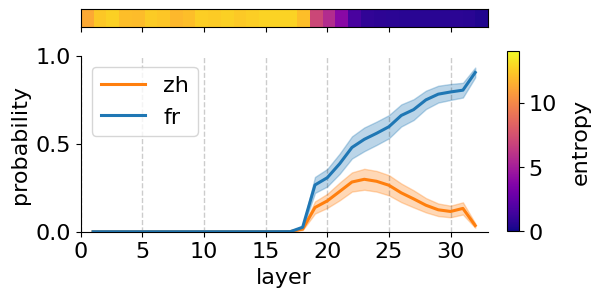

In [17]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}
fig, ax, ax2 = plot_ci_plus_heatmap(latent_token_probs, entropy, 'zh', color='tab:orange', tik_step=size2tik[model_size], do_colorbar=True, #, do_colorbar=(model_size=='70b'),
nums=[.99, 0.18, 0.025, 0.6])
if target_lang != 'zh':
    plot_ci(ax2, out_token_probs, target_lang, color='tab:blue', do_lines=False)
ax2.set_xlabel('layer')
ax2.set_ylabel('probability')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
ax2.set_ylim(0, 1)
# make xticks start from 1
# put legend on the top left
ax2.legend(loc='upper left')
os.makedirs(f'{out_dir}/translation', exist_ok=True)

plt.savefig(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_probas_ent.pdf', dpi=300, bbox_inches='tight')

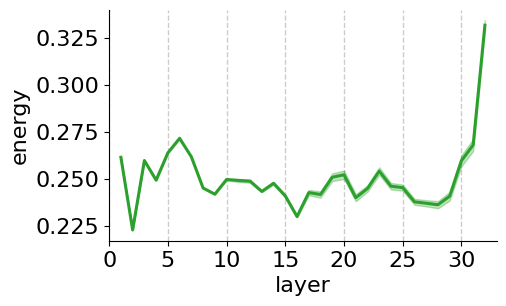

In [18]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}

fig, ax2 = plt.subplots(figsize=(5,3))
plot_ci(ax2, energy, 'energy', color='tab:green', do_lines=True, tik_step=size2tik[model_size])
ax2.set_xlabel('layer')
ax2.set_ylabel('energy')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
os.makedirs(f'{out_dir}/translation', exist_ok=True)
plt.savefig(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_energy.pdf', dpi=300, bbox_inches='tight')